<a href="https://colab.research.google.com/github/Sarah-0405/Cold_Spots_Bayern/blob/main/LSTuColdSpots_staedte_ueber_50tsd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook berechnet die LST der bayrischen Städte mit > 50.000 EW
- mittlere LST des gesamten Stadtgebiets pro Jahr (Sommer) von 2019-2024
- berechnet anhand dessen die Cold Spots a) für jedes Jahr und b) für den Gesamtzeitraum, also Cold Spots die in jedem Jahr solche waren

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Bibliotheken installieren und Zugriffe gewähren
import ee
import geemap
import folium
from datetime import datetime
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import matplotlib.pyplot as plt


ee.Authenticate()
ee.Initialize(project="ee-sarahheinz0405")


In [3]:
staedte_ueber_50tsd_polygone = gpd.read_file("/content/drive/MyDrive/Cold Spots Bayern/grenzen_ueber_50tsd.gpkg")
staedte_ueber_50tsd_polygone.head()

,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name,geometry
0,11.360777,48.061624,11.722910,48.248116,116687199,relation,62428,48.137108,11.575382,boundary,administrative,12,0.799006,city,Munich,"Munich, Bavaria, Germany","MULTIPOLYGON (((11.36078 48.15807, 11.36085 48..."
1,10.988733,49.331434,11.282596,49.540753,115962439,relation,62780,49.453872,11.077298,boundary,administrative,12,0.709195,city,Nuremberg,"Nuremberg, Bavaria, Germany","MULTIPOLYGON (((10.98873 49.53654, 10.98906 49..."
2,10.763362,48.258144,10.959333,48.458654,116219980,relation,62407,48.369034,10.897952,boundary,administrative,12,0.679385,city,Augsburg,"Augsburg, Bavaria, Germany","MULTIPOLYGON (((10.76336 48.30213, 10.76336 48..."
3,12.029075,48.966746,12.191608,49.076416,119951011,relation,62411,49.019533,12.097487,boundary,administrative,12,0.670191,city,Regensburg,"Regensburg, Bavaria, Germany","MULTIPOLYGON (((12.02907 49.01102, 12.02908 49..."
4,11.255908,48.683877,11.503422,48.822891,116627625,relation,62381,48.763016,11.425040,boundary,administrative,12,0.625744,city,Ingolstadt,"Ingolstadt, Bavaria, Germany","MULTIPOLYGON (((11.25591 48.77946, 11.25634 48..."


# Anzahl der Szenen bei unterschiedlicher Wolkenbedeckung überprüfen

Zeitraum: Juni bis August der Jahre 2019-2024

In [ ]:
staedte_ueber_50tsd_polygone = gpd.read_file("/content/drive/MyDrive/Cold Spots Bayern/grenzen_ueber_50tsd.gpkg")

# Anzahl der Szenen bei unterschiedlicher Wolkenbedeckung überprüfen

# Zeiträume für die Monate Juni bis August der Jahre 2019-2024
years = range(2019, 2025)  # Jahre von 2019 bis einschließlich 2024
date_ranges = [(f'{year}-06-01', f'{year}-08-31') for year in years]

# Cloud Cover-Werte
cloud_cover_values = [5, 10, 20, 30, 40, 50]

results = {}
# Loop directly through the GeoDataFrame rows
for index, row in staedte_ueber_50tsd_polygone.iterrows():
    city_name = row['name']
    geometry = row['geometry']

    # Convert the shapely geometry to an Earth Engine geometry
    region = ee.Geometry(mapping(geometry))

    results[city_name] = {}
    for cloud_cover in cloud_cover_values:
        total_scenes = 0
        # Schleife über die definierten Zeiträume
        for start_date, end_date in date_ranges:
            landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate(start_date, end_date) \
                .filterBounds(region) \
                .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover))
            num_scenes = landsat.size().getInfo()
            total_scenes += num_scenes # Anzahl der Szenen für den aktuellen Zeitraum hinzufügen

        results[city_name][cloud_cover] = total_scenes # Gesamtzahl der Szenen für alle Zeiträume speichern

# Ergebnisse in Tabelle ausgeben
print("Gesamtanzahl der Szenen für verschiedene Cloud Cover-Werte (Juni-August, 2019-2024):")
print("Stadt\t| 5%\t| 10%\t| 20%\t| 30%\t| 40%\t| 50%")
print("-" * 80) # Trennlinie angepasst
for city_name, data in results.items():
    row = f"{city_name}\t|"
    for cloud_cover in cloud_cover_values:
        # Stellen Sie sicher, dass der Wert in der Ergebnistabelle vorhanden ist, bevor Sie ihn formatieren
        scene_count = data.get(cloud_cover, 0) # Standardwert 0, falls kein Ergebnis gefunden wurde
        row += f" {scene_count}\t|"
    print(row)

KeyboardInterrupt: 

=> 10 Prozent wählen und mittlere Pixel-LST für alle Städte in dem Zeitraum berechnen

# Durchschnitts-LST für Gesamt-Stadtgebiet für jede Szene

Wolkenmaskierung

In [4]:
def maskClouds(image):
    # QA_PIXEL-Band auswählen
    qa_band = image.select('QA_PIXEL')

    # Bitmasken für Wolkenschatten (Bit 3) und Wolken (Bit 5) definieren
    cloud_shadow_bitmask = (1 << 3)  # 00001000 = 8
    cloud_bitmask = (1 << 5)         # 00100000 = 32

    # Prüfen, ob die relevanten Bits nicht gesetzt sind (d.h. wolkenfreie Pixel)
    mask = qa_band.bitwiseAnd(cloud_shadow_bitmask).eq(0).And(
           qa_band.bitwiseAnd(cloud_bitmask).eq(0))

    # Maske auf das Bild anwenden
    return image.updateMask(mask)


In [5]:
# Funktion zur Berechnung der LST
def calculateLST(image):
    kelvin = image.select('ST_B10').multiply(0.00341802).add(149.0)  # Radiance -> Kelvin
    lst_celsius = kelvin.subtract(273.15).rename('LST_Celsius')  # Kelvin -> Celsius
    return image.addBands(lst_celsius)


In [ ]:
# Durchschnitts-LST für Gesamt-Stadtgebiet für jede Szene und Jahresdurchschnitte

# Zeiträume für die Monate Juni bis August der Jahre 2019-2024
years = range(2019, 2025)  # Jahre von 2019 bis einschließlich 2024
date_ranges = [(f'{year}-06-01', f'{year}-08-31') for year in years]


# Cloud Cover-Grenzwert
cloud_cover_threshold = 10

yearly_avg_lst = {} # Dictionary zum Speichern der Jahresdurchschnitte
total_avg_lst_values = [] # Liste zum Speichern aller durchschnittlichen LST-Werte zur Berechnung des Gesamtdurchschnitts

# Loop directly through the GeoDataFrame rows
for index, row in staedte_ueber_50tsd_polygone.iterrows():
    city_name = row['name']
    geometry = row['geometry']

    # Convert the shapely geometry to an Earth Engine geometry
    region = ee.Geometry(mapping(geometry))

    print(f"\nVerarbeitung von Szenen für {city_name} (Cloud Cover < {cloud_cover_threshold}%)")

    city_lst_values = [] # Liste zum Speichern der LST-Werte für die aktuelle Stadt

    # Schleife über die definierten Zeiträume (Jun-Aug für jedes Jahr)
    for year, (start_date, end_date) in zip(years, date_ranges):
        print(f"  Zeitraum: {start_date} bis {end_date}")

        landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover_threshold)) \
            .map(maskClouds) \
            .map(calculateLST)

        # Anzahl der gefundenen Szenen
        num_scenes_in_period = landsat.size().getInfo()
        print(f"    Anzahl der gefundenen Szenen: {num_scenes_in_period}")

        # Nur fortfahren, wenn Szenen gefunden wurden
        if num_scenes_in_period > 0:
            # Schleife über jede Szene im Zeitraum
            for image_index in range(num_scenes_in_period):
                image = ee.Image(landsat.toList(num_scenes_in_period).get(image_index))

                # Datum der Szene extrahieren
                scene_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

                # Durchschnittliche LST über das Stadtgebiet berechnen
                avg_lst_image = image.select('LST_Celsius').reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region,
                    scale=30 # Auflösung in Metern
                )

                # Den Wert extrahieren und prüfen, ob er vorhanden ist
                avg_lst_value = avg_lst_image.get('LST_Celsius').getInfo()

                if avg_lst_value is not None:
                    print(f"    Szene vom {scene_date}: Durchschnittliche LST = {avg_lst_value:.2f} °C")
                    city_lst_values.append(avg_lst_value)
                    total_avg_lst_values.append(avg_lst_value) # LST-Wert zum Gesamtdurchschnitt hinzufügen

        # Berechnung des Jahresdurchschnitts, wenn Szenen vorhanden waren
        if city_lst_values:
            if year not in yearly_avg_lst:
                yearly_avg_lst[year] = {}
            if city_name not in yearly_avg_lst[year]:
                yearly_avg_lst[year][city_name] = []
            yearly_avg_lst[year][city_name].extend(city_lst_values)
            city_lst_values = [] # Liste für die Stadt für den nächsten Zeitraum zurücksetzen


# Berechnung und Ausgabe der Jahresdurchschnitte
print("\nJahresdurchschnitte der LST für jede Stadt (Juni-August, 2019-2024):")
print("Stadt\t| 2019\t| 2020\t| 2021\t| 2022\t| 2023\t| 2024")
print("-" * 80)
for index, row in staedte_ueber_50tsd_polygone.iterrows():
    city_name = row['name']
    row_output = f"{city_name}\t|"
    for year in years:
        if year in yearly_avg_lst and city_name in yearly_avg_lst[year] and yearly_avg_lst[year][city_name]:
            avg_for_year_city = sum(yearly_avg_lst[year][city_name]) / len(yearly_avg_lst[year][city_name])
            row_output += f" {avg_for_year_city:.2f}\t|"
        else:
            row_output += f" ---\t|" # Zeigt "---" an, wenn keine Daten für das Jahr/die Stadt vorhanden sind
    print(row_output)


# Berechnung und Ausgabe des Gesamtdurchschnitts aller Szenen
if total_avg_lst_values:
    overall_avg_lst = sum(total_avg_lst_values) / len(total_avg_lst_values)
    print(f"\nGesamtdurchschnittliche LST über alle Städte und Jahre (Juni-August, 2019-2024): {overall_avg_lst:.2f} °C")
else:
    print("\nKeine LST-Daten gefunden, um den Gesamtdurchschnitt zu berechnen.")


Verarbeitung von Szenen für Munich (Cloud Cover < 10%)
  Zeitraum: 2019-06-01 bis 2019-08-31
    Anzahl der gefundenen Szenen: 6
    Szene vom 2019-06-24: Durchschnittliche LST = 30.46 °C
    Szene vom 2019-07-26: Durchschnittliche LST = 39.72 °C
    Szene vom 2019-08-11: Durchschnittliche LST = 31.97 °C
    Szene vom 2019-08-27: Durchschnittliche LST = 31.88 °C
    Szene vom 2019-06-24: Durchschnittliche LST = 30.43 °C
    Szene vom 2019-08-27: Durchschnittliche LST = 31.86 °C
  Zeitraum: 2020-06-01 bis 2020-08-31
    Anzahl der gefundenen Szenen: 4
    Szene vom 2020-08-06: Durchschnittliche LST = 29.21 °C
    Szene vom 2020-06-26: Durchschnittliche LST = 32.63 °C
    Szene vom 2020-07-28: Durchschnittliche LST = 37.01 °C
    Szene vom 2020-07-28: Durchschnittliche LST = 36.98 °C
  Zeitraum: 2021-06-01 bis 2021-08-31
    Anzahl der gefundenen Szenen: 1
    Szene vom 2021-06-13: Durchschnittliche LST = 30.15 °C
  Zeitraum: 2022-06-01 bis 2022-08-31
    Anzahl der gefundenen Szenen: 6

In [ ]:
# Berechnung und Speicherung der Jahresdurchschnitte in einem DataFrame
data_for_df = []
for index, row in staedte_ueber_50tsd_polygone.iterrows():
    city_name = row['name']
    row_data = {'Stadt': city_name}
    for year in years:
        if year in yearly_avg_lst and city_name in yearly_avg_lst[year] and yearly_avg_lst[year][city_name]:
            avg_for_year_city = sum(yearly_avg_lst[year][city_name]) / len(yearly_avg_lst[year][city_name])
            row_data[str(year)] = round(avg_for_year_city, 2) # LST auf 2 Dezimalstellen runden
        else:
            row_data[str(year)] = None # Oder 0, je nachdem, wie fehlende Daten dargestellt werden sollen
    data_for_df.append(row_data)

# DataFrame erstellen
df_yearly_avg_lst = pd.DataFrame(data_for_df)

# Spaltenreihenfolge festlegen (optional, für bessere Lesbarkeit)
columns_order = ['Stadt'] + [str(year) for year in years]
df_yearly_avg_lst = df_yearly_avg_lst[columns_order]

# Tabelle anzeigen
print("\nJahresdurchschnitte der LST für jede Stadt (Juni-August, 2019-2024) - Tabelle:")
display(df_yearly_avg_lst)

# DataFrame speichern (Beispiel: als CSV-Datei)
output_csv_path = "/content/drive/MyDrive/Cold Spots Bayern/jahresdurchschnitt_sommer_lst_staedte.csv" # Pfad anpassen
df_yearly_avg_lst.to_csv(output_csv_path, index=False)
print(f"\nTabelle wurde gespeichert unter: {output_csv_path}")


NameError: name 'years' is not defined

# Cold Spots
Algorithmus anwenden auf alle Städte und Zeiträume

Getis-Ord Gi*-Algorithmus wird verwendet

In [6]:
jahresdurchschnitt_sommer_lst_staedte = pd.read_csv("/content/drive/MyDrive/Cold Spots Bayern/jahresdurchschnitt_sommer_lst_staedte.csv")
jahresdurchschnitt_sommer_lst_staedte.head()

,Stadt,2019,2020,2021,2022,2023,2024
0,Munich,32.72,33.96,30.15,34.01,37.66,31.84
1,Nuremberg,35.79,34.21,31.93,38.04,36.93,32.92
2,Augsburg,32.07,32.24,29.64,33.68,35.77,32.70
3,Regensburg,34.91,33.67,28.57,33.37,37.27,35.00
4,Ingolstadt,32.41,31.77,28.24,35.82,38.46,32.97


dataframes erstellen, die für jede Stadt die Pixelkoordinaten mitsamt deren LST-Wert enthalten
- für jedes der 5 Jahre einzeln
- für den 5-Jahres-Durchschnitt

zunächst: Beispielhaftes Vorgehen mit Nürnberg

In [7]:
!pip install geemap
!pip install geopandas
!pip install geopy
!pip install folium
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install rasterio
!pip install seaborn
!pip install shapely
!pip install sklearn
!pip install pysal

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [8]:
# Importieren Sie notwendige Bibliotheken
import ee
import geemap
import folium
from datetime import datetime
import geopandas as gpd
from shapely.geometry import mapping, Point
import pandas as pd
import matplotlib.pyplot as plt
import pysal.lib as ps
import pysal.explore as pe

/usr/local/lib/python3.11/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [ ]:
# Laden Sie die Geometrien der Städte (falls noch nicht geschehen)
staedte_ueber_50tsd_polygone = gpd.read_file("/content/drive/MyDrive/Cold Spots Bayern/grenzen_ueber_50tsd.gpkg")

# Filtern Sie das Polygon für Nürnberg
# IMPORTANT: Double check the exact spelling in your geodataframe
nuernberg_polygon = staedte_ueber_50tsd_polygone[staedte_ueber_50tsd_polygone['name'] == 'Nuremberg'] # Using 'Nuremberg' as per your correction

# Überprüfen Sie, ob das Polygon gefunden wurde
if nuernberg_polygon.empty:
    print("Polygon für Nürnberg nicht gefunden. Bitte überprüfen Sie den Stadtnamen.")
    # If the polygon is not found, the rest of the code for Nuremberg won't run.
    # You might want to add an exit() or sys.exit() here if this is a critical error.
else:
    nuernberg_geometry_shapely = nuernberg_polygon.iloc[0]['geometry']
    nuernberg_region_ee = ee.Geometry(mapping(nuernberg_geometry_shapely))

    # Definieren Sie die Jahre und den Zeitraum (Juni bis August)
    years = range(2019, 2025) # Jahre 2019 bis einschließlich 2024
    cloud_cover_threshold = 10

    all_pixel_data_across_years = []

    # Initialize a geemap map for visualization (if not already initialized)
    try:
        Map # Check if Map object exists from previous cells
    except NameError:
        print("geemap.Map object not found, initializing a new one for visualization.")
        Map = geemap.Map(center=[nuernberg_geometry_shapely.centroid.y, nuernberg_geometry_shapely.centroid.x], zoom=10)


    # Schleife über jedes Jahr
    for year in years:
        start_date = f'{year}-06-01'
        end_date = f'{year}-08-31'

        print(f"\nVerarbeitung von Landsat-Daten für Nürnberg im Zeitraum {start_date} bis {end_date}...")

        # Filtern, Maskieren und LST berechnen
        # Ensure maskClouds is applied to the collection
        landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start_date, end_date) \
            .filterBounds(nuernberg_region_ee) \
            .filter(ee.Filter.lt('CLOUD_COVER', cloud_cover_threshold)) \
            .map(maskClouds) \
            .map(calculateLST) # Verwenden Sie Ihre vorhandene calculateLST Funktion

        num_scenes = landsat_collection.size().getInfo()
        print(f"Anzahl der gefundenen Szenen: {num_scenes}")

        # --- Add Visualization Step (for diagnosis) ---
        # You can choose a specific year/scene to visualize here
        # Example: Visualize the first scene found for 2019
        if num_scenes > 0 and year == 2019: # Set the year you want to inspect
             print(f"  Attempting to visualize a masked scene for {year}...")
             # Get the first image from the collection for visualization
             first_image = ee.Image(landsat_collection.first())
             if first_image:
                 try:
                     # Define visualization parameters for LST (adjust min/max as needed)
                     lst_vis_params = {
                         'min': 15,
                         'max': 35,
                         'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
                     }
                     # Add the masked LST band to the map, clipped to the city boundary
                     # Use the masked LST band directly from the processed collection
                     Map.addLayer(first_image.select('LST_Celsius').clip(nuernberg_region_ee), lst_vis_params, f'Masked LST {year} (Scene 1)')
                     # Add the city boundary
                     Map.addLayer(nuernberg_region_ee, {'color': 'FF0000'}, 'Nürnberg Boundary')
                     print(f"  Added masked LST layer for {year} to the map. Inspect the map.")
                 except Exception as viz_e:
                     print(f"  Could not add visualization layer for {year}: {viz_e}")
             else:
                 print(f"  Could not get the first image for visualization in year {year}.")
        # --- End Visualization Step ---


        # Wenn Szenen gefunden wurden, verarbeiten Sie sie
        if num_scenes > 0:
            scenes_list = landsat_collection.toList(num_scenes)

            # Function to extract pixel values and coordinates for a single image
            def extract_pixels_from_image(image, region, current_year):
                # Get scene date for logging
                scene_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()
                print(f"  Attempting to extract pixels for scene date: {scene_date}")

                # Select the LST band which is already masked
                masked_lst = image.select('LST_Celsius')

                # Get the mask from the LST band
                mask = masked_lst.mask()

                # Add Latitude and Longitude bands
                lonLat_image = ee.Image.pixelLonLat()

                # Apply the LST mask to the Latitude and Longitude bands
                masked_lonLat = lonLat_image.updateMask(mask)

                # Combine the masked LST and masked LonLat bands
                array_image = masked_lst.addBands(masked_lonLat)


                pixel_data = array_image.reduceRegion(
                    reducer=ee.Reducer.toList(),
                    geometry=region,
                    scale=30,
                    maxPixels=1e9
                )

                # Use getInfo() here to trigger the Earth Engine computation
                # Use .get('key', default_value) to safely access elements
                pixel_data_info = pixel_data.getInfo()

                # Now all lists should ideally have the same length because the mask was applied consistently
                lst_values = pixel_data_info.get('LST_Celsius', []) # Default to empty list
                lats = pixel_data_info.get('latitude', []) # Default to empty list
                lons = pixel_data_info.get('longitude', []) # Default to empty list


                # Add diagnostic prints
                # print(f"    reduceRegion result for {scene_date}: {pixel_data_info}") # Can be very large, use with caution
                print(f"    Length of LST values for scene {scene_date}: {len(lst_values)}")
                print(f"    Length of Lat values for scene {scene_date}: {len(lats)}")
                print(f"    Length of Lon values for scene {scene_date}: {len(lons)}")


                # Check if lists are empty or inconsistent length - this check should now pass if the mask fix worked
                if not lst_values or not lats or not lons or \
                   len(lst_values) != len(lats) or len(lst_values) != len(lons):
                    print(f"    Warnung: Keine oder inkonsistente Pixeldaten für Jahr {current_year}, Szene {scene_date}. Skipping this scene.")
                    return []

                pixel_list = []
                for j in range(len(lst_values)):
                    pixel_list.append({
                        'LST_Celsius': lst_values[j],
                        'longitude': lons[j],
                        'latitude': lats[j],
                        'year': current_year, # Fügen Sie das Jahr hinzu
                        'scene_date': scene_date # Optional: Szene-Datum hinzufügen
                    })

                print(f"  Successfully extracted {len(pixel_list)} pixels for scene date: {scene_date}")
                return pixel_list

            # Schleife über jede Szene in diesem Jahr
            for i in range(num_scenes):
                image = ee.Image(scenes_list.get(i))
                current_year = year
                current_scene_pixel_data = extract_pixels_from_image(image, nuernberg_region_ee, current_year)
                all_pixel_data_across_years.extend(current_scene_pixel_data)

        else:
            print(f"Keine Szenen für das Jahr {year} gefunden.")

    # If you added the map, display it here (in a separate cell ideally)
    # display(Map)


    # Wenn Daten gesammelt wurden, erstellen Sie den GeoDataFrame mit allen Jahresdaten
    if all_pixel_data_across_years:
        df_nuernberg_pixels_all_years = pd.DataFrame(all_pixel_data_across_years)

        # Erstellen Sie die Geometrie-Spalte
        geometry_all_years = [Point(xy) for xy in zip(df_nuernberg_pixels_all_years['longitude'], df_nuernberg_pixels_all_years['latitude'])]
        gdf_nuernberg_pixels_all_years = gpd.GeoDataFrame(df_nuernberg_pixels_all_years, geometry=geometry_all_years)
        gdf_nuernberg_pixels_all_years.crs = "EPSG:4326"

        print("\nGeoDataFrame für Nürnberg mit Pixel-LST für alle Jahre (2019-2024) erstellt:")
        display(gdf_nuernberg_pixels_all_years.head())

        # Sie können diesen GeoDataFrame speichern, wenn Sie möchten
        output_all_years_geojson_path = "/content/drive/MyDrive/Cold Spots Bayern/nuernberg_pixels_lst_2019_2024.geojson"
        gdf_nuernberg_pixels_all_years.to_file(output_all_years_geojson_path, driver='GeoJSON')
        print(f"\nGeoDataFrame wurde gespeichert unter: {output_all_years_geojson_path}")



Verarbeitung von Landsat-Daten für Nürnberg im Zeitraum 2019-06-01 bis 2019-08-31...
Anzahl der gefundenen Szenen: 5
  Attempting to visualize a masked scene for 2019...
  Added masked LST layer for 2019 to the map. Inspect the map.
  Attempting to extract pixels for scene date: 2019-06-24
    Length of LST values for scene 2019-06-24: 207434
    Length of Lat values for scene 2019-06-24: 207434
    Length of Lon values for scene 2019-06-24: 207434
  Successfully extracted 207434 pixels for scene date: 2019-06-24
  Attempting to extract pixels for scene date: 2019-07-26
    Length of LST values for scene 2019-07-26: 207435
    Length of Lat values for scene 2019-07-26: 207435
    Length of Lon values for scene 2019-07-26: 207435
  Successfully extracted 207435 pixels for scene date: 2019-07-26
  Attempting to extract pixels for scene date: 2019-08-11
    Length of LST values for scene 2019-08-11: 193330
    Length of Lat values for scene 2019-08-11: 193330
    Length of Lon values for

,LST_Celsius,longitude,latitude,year,scene_date,geometry
0,35.249363,10.990591,49.540615,2019,2019-06-24,POINT (10.99059 49.54062)
1,33.953933,10.991005,49.540608,2019,2019-06-24,POINT (10.99101 49.54061)
2,34.124834,10.991420,49.540601,2019,2019-06-24,POINT (10.99142 49.5406)
3,34.459800,10.991834,49.540594,2019,2019-06-24,POINT (10.99183 49.54059)
4,35.386084,10.992249,49.540587,2019,2019-06-24,POINT (10.99225 49.54059)



GeoDataFrame wurde gespeichert unter: /content/drive/MyDrive/Cold Spots Bayern/nuernberg_pixels_lst_2019_2024.geojson


In [9]:
gdf_nuernberg_pixels_all_years = gpd.read_file("/content/drive/MyDrive/Cold Spots Bayern/nuernberg_pixels_lst_2019_2024.geojson")
print(gdf_nuernberg_pixels_all_years.head(10))

   LST_Celsius  longitude   latitude  year scene_date  \
0    35.249363  10.990591  49.540615  2019 2019-06-24   
1    33.953933  10.991005  49.540608  2019 2019-06-24   
2    34.124834  10.991420  49.540601  2019 2019-06-24   
3    34.459800  10.991834  49.540594  2019 2019-06-24   
4    35.386083  10.992249  49.540587  2019 2019-06-24   
5    35.604837  10.992663  49.540580  2019 2019-06-24   
6    35.765484  10.993077  49.540572  2019 2019-06-24   
7    35.871442  10.993492  49.540565  2019 2019-06-24   
8    35.895368  10.993906  49.540558  2019 2019-06-24   
9    33.707836  10.989337  49.540367  2019 2019-06-24   

                    geometry  
0  POINT (10.99059 49.54062)  
1  POINT (10.99101 49.54061)  
2   POINT (10.99142 49.5406)  
3  POINT (10.99183 49.54059)  
4  POINT (10.99225 49.54059)  
5  POINT (10.99266 49.54058)  
6  POINT (10.99308 49.54057)  
7  POINT (10.99349 49.54057)  
8  POINT (10.99391 49.54056)  
9  POINT (10.98934 49.54037)  


In [11]:
from esda.getisord import G_Local
from libpysal.weights import KNN
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point # Import Point needed for GeoDataFrame creation


In [13]:
# räumliche Nachbarschaft definieren

def create_knn_weights(gdf, k=12):  # KNN mit 12 Nachbarn
    coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))
    w = KNN.from_array(coords, k=k)
    return w

w_nuernberg = create_knn_weights(gdf_nuernberg_pixels_all_years, k=12)

/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 207424 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Warnung bedeutet, dass KNN-Matrix nicht zusammenhängend, sondern teils isoliert ist, es wurden aber trotzdem Nachbarschaften gefunden

für erstmal nur ein Jahr Gi* berechnen


🔍 Durchführung der Gi*-Analyse für das Jahr: 2020...
  Berechne KNN-Gewichtsmatrix (k=12) für Jahr 2020...
  Konvertiere Daten für Jahr 2020 nach EPSG:25832 (UTM 32N) für metrische Distanzen.


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  Warnung: Gewichtsmatrix für Jahr 2020 ist nicht vollständig verbunden (2 Komponenten).
  Berechne Gi*-Statistik für Jahr 2020...

  Ergebnisse für Jahr 2020:
spot_type
Cold Spot          130608
Not Significant     76711
Hot Spot              117
Name: count, dtype: int64

Gi*-Ergebnisse für 2020 wurden gespeichert unter: /content/drive/MyDrive/Cold Spots Bayern/nuernberg_gi_star_results_2020.geojson

Attributtabelle des GeoDataFrames mit Gi*-Ergebnissen für das Zieljahr:


,longitude,latitude,avg_LST_Celsius,geometry,gi_star_z,p_value,significant,spot_type
0,10.989183,49.536591,24.981631,POINT (10.98918 49.53659),-1.656873,0.001,True,Cold Spot
1,10.989194,49.536861,25.518260,POINT (10.98919 49.53686),-1.585820,0.001,True,Cold Spot
2,10.989227,49.537670,27.897202,POINT (10.98923 49.53767),-0.899271,0.002,True,Cold Spot
3,10.989304,49.539558,28.899821,POINT (10.9893 49.53956),-0.549798,0.024,True,Cold Spot
4,10.989315,49.539828,29.009198,POINT (10.98931 49.53983),-0.704050,0.006,True,Cold Spot


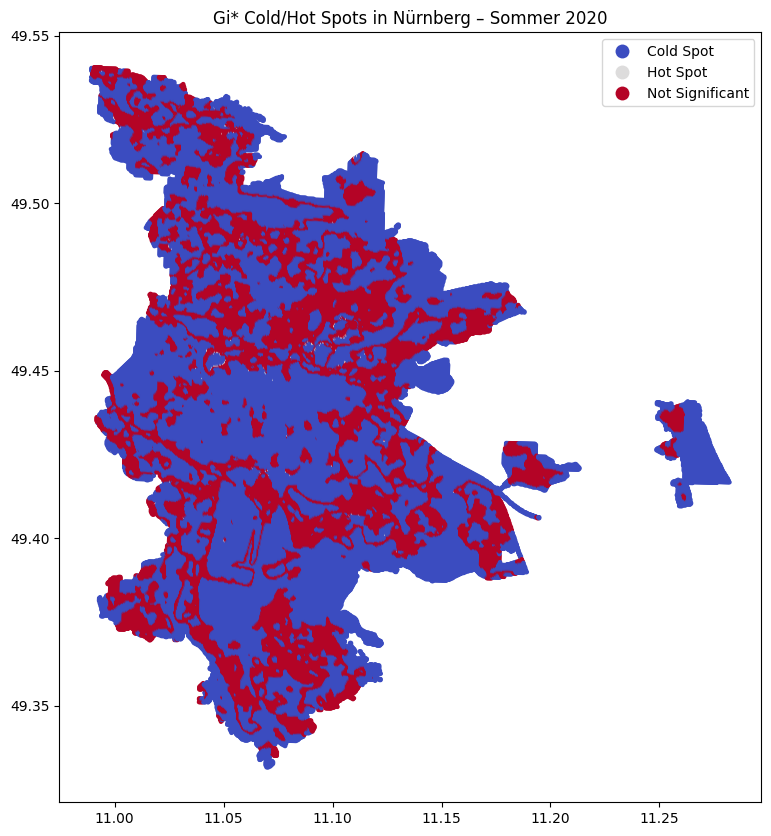

In [20]:
# Annahme: gdf_nuernberg_pixels_all_years ist bereits geladen

# --- Jahr für die Analyse festlegen ---
target_year = 2020 # Ändere diese Jahreszahl für die Analyse eines anderen Jahres

print(f"\n🔍 Durchführung der Gi*-Analyse für das Jahr: {target_year}...")

# Filtern Sie die Daten für das Zieljahr
# Stelle sicher, dass das Zieljahr im DataFrame vorhanden ist
if target_year in gdf_nuernberg_pixels_all_years['year'].unique():
    gdf_year = gdf_nuernberg_pixels_all_years[gdf_nuernberg_pixels_all_years['year'] == target_year].copy()

    # Speichern Sie das CRS des ursprünglichen GeoDataFrames für dieses Jahr
    # Es ist wichtig, dass das ursprüngliche CRS vorhanden ist
    original_crs = gdf_year.crs
    if original_crs is None:
        print(f"⚠️ CRS für Jahr {target_year} ist None. Bitte stellen Sie sicher, dass der GeoDataFrame ein CRS hat.")
        # Du musst ein CRS setzen, damit die Distanzberechnung funktioniert
        # Zum Beispiel, wenn deine Koordinaten in WGS84 sind:
        # gdf_year.crs = "EPSG:4326"
        # original_crs = gdf_year.crs
        # print(f"  Temporäres CRS auf EPSG:4326 gesetzt für Jahr {target_year}.")
        # Oder handle den Fehler entsprechend

    # Berechnen Sie den Jahresdurchschnitt der LST pro Pixel für dieses Jahr
    # (Falls für ein Pixel mehrere Szenen in diesem Jahr vorhanden sind)
    gdf_current_year_avg = gdf_year.groupby(['longitude', 'latitude']).agg(
        avg_LST_Celsius=('LST_Celsius', 'mean')
        # Die Geometrie wird hier absichtlich nicht direkt aggregiert
    ).reset_index()

    # Füge die Geometrie-Spalte wieder hinzu und erstelle einen GeoDataFrame
    # Nutze die ursprünglichen Geometrien der eindeutigen Pixel
    unique_pixels_geometry = gdf_year[['longitude', 'latitude', 'geometry']].drop_duplicates(subset=['longitude', 'latitude']).set_index(['longitude', 'latitude'])
    gdf_current_year_avg = gdf_current_year_avg.set_index(['longitude', 'latitude']).join(unique_pixels_geometry).reset_index()

    # Konvertiere den DataFrame explizit in einen GeoDataFrame und weise das ursprüngliche CRS zu
    gdf_current_year_avg = gpd.GeoDataFrame(gdf_current_year_avg, geometry='geometry', crs=original_crs)


    # Stellen Sie sicher, dass es Daten gibt, bevor Sie die Analyse durchführen
    # Gi* benötigt mindestens 2 Punkte. Für KNN mit k=12 benötigt es sinnvollerweise mehr.
    k = 12 # Anzahl der Nachbarn
    min_points_for_gi = k + 1 # Minimum Punkte = k + 1
    if not gdf_current_year_avg.empty and len(gdf_current_year_avg) >= min_points_for_gi:
        # Räumliche Nachbarschaft definieren (KNN mit k=12)
        try:
            print(f"  Berechne KNN-Gewichtsmatrix (k={k}) für Jahr {target_year}...")
            # Stellen Sie sicher, dass das CRS projiziert ist oder konvertieren Sie es kurzfristig
            # Konvertiere in ein metrisches CRS vor der KNN-Berechnung, wenn es noch nicht projiziert ist
            gdf_year_spatial = gdf_current_year_avg.copy() # Kopie erstellen, um das Original nicht zu ändern
            if gdf_year_spatial.crs is None or gdf_year_spatial.crs.is_geographic:
                print(f"  Konvertiere Daten für Jahr {target_year} nach EPSG:25832 (UTM 32N) für metrische Distanzen.")
                gdf_year_spatial = gdf_year_spatial.to_crs(epsg=25832)


            w_year = KNN.from_dataframe(gdf_year_spatial, k=k)
            w_year.transform = 'R' # Zeilenstandardisierung anwenden

            # Prüfen auf Konnektivität
            if w_year.n_components > 1:
                 print(f"  Warnung: Gewichtsmatrix für Jahr {target_year} ist nicht vollständig verbunden ({w_year.n_components} Komponenten).")


            # Skaliere die LST-Werte
            # Verwenden Sie die Daten aus dem originalen gdf_current_year_avg für die LST-Werte
            lst_scaled = StandardScaler().fit_transform(gdf_current_year_avg[['avg_LST_Celsius']])

            # Gi* berechnen
            print(f"  Berechne Gi*-Statistik für Jahr {target_year}...")
            # Wir verwenden permutations=999, um p_sim zu erhalten
            g_local = G_Local(lst_scaled.flatten(), w_year, permutations=999)

            # Werte dem GeoDataFrame hinzufügen
            # Füge die Ergebnisse zum GeoDataFrame mit den Jahresdurchschnittswerten hinzu
            gdf_current_year_avg['gi_star_z'] = g_local.Zs       # Z-Scores
            gdf_current_year_avg['p_value'] = g_local.p_sim     # Pseudo p-Werte aus Simulation

            # Klassifiziere Hot/Cold/Not Significant basierend auf p_sim < 0.05 und dem Z-Score
            gdf_current_year_avg['significant'] = gdf_current_year_avg['p_value'] < 0.05

            gdf_current_year_avg['spot_type'] = gdf_current_year_avg.apply(
                lambda row: 'Cold Spot' if row['significant'] and row['gi_star_z'] < 0 else (
                            'Hot Spot' if row['significant'] and row['gi_star_z'] > 0 else 'Not Significant'), axis=1
            )

            # Zusammenfassung der Ergebnisse anzeigen
            print(f"\n  Ergebnisse für Jahr {target_year}:")
            print(gdf_current_year_avg['spot_type'].value_counts())

            # Ergebnisse des Jahres speichern (Optional)
            output_year_geojson_path = f"/content/drive/MyDrive/Cold Spots Bayern/nuernberg_gi_star_results_{target_year}.geojson"
            try:
                 gdf_current_year_avg.to_file(output_year_geojson_path, driver='GeoJSON')
                 print(f"\nGi*-Ergebnisse für {target_year} wurden gespeichert unter: {output_year_geojson_path}")
            except Exception as e:
                 print(f"\nFehler beim Speichern der Gi*-Ergebnisse für {target_year}: {e}")

            # Optional: Zeige die Attributtabelle des Ergebnis-GeoDataFrames
            if 'gdf_current_year_avg' in globals() and not gdf_current_year_avg.empty:
                print("\nAttributtabelle des GeoDataFrames mit Gi*-Ergebnissen für das Zieljahr:")
                display(gdf_current_year_avg.head()) # Zeigt die ersten 5 Zeilen
            else:
               print("\nDer GeoDataFrame mit den Gi*-Ergebnissen für das Zieljahr wurde nicht erstellt oder ist leer.")

            # Optional: Karte der Hot/Cold Spots für dieses Jahr anzeigen
            fig, ax = plt.subplots(figsize=(10, 10))
            gdf_current_year_avg.plot(column='spot_type', categorical=True, legend=True,
                           cmap='coolwarm', markersize=5, ax=ax)
            ax.set_title(f"Gi* Cold/Hot Spots in Nürnberg – Sommer {target_year}")
            plt.show()

        except Exception as e:
            print(f"Fehler bei der Durchführung der Gi*-Analyse für Jahr {target_year}: {e}")
            print("Stellen Sie sicher, dass genügend Punkte für die KNN-Analyse vorhanden sind und das CRS geeignet ist.")
            print(f"Fehlerdetails: {e}") # Zusätzliche Fehlerdetails ausgeben
    else:
        print(f"  Keine ausreichenden Daten ({len(gdf_current_year_avg)} Punkte) für die Gi*-Analyse für Jahr {target_year}.")
else:
    print(f"Jahr {target_year} nicht im GeoDataFrame gefunden.")

gleiche Methode wie oben, nur Schleife über alle Jahre:

In [21]:
# Annahme: gdf_nuernberg_pixels_all_years ist bereits geladen
# Stellen Sie sicher, dass der GeoDataFrame ein CRS hat (wichtig für from_dataframe)
if gdf_nuernberg_pixels_all_years.crs is None:
    print("⚠️ CRS für gdf_nuernberg_pixels_all_years ist None. Bitte setzen Sie ein CRS.")
    # Beispiel: Wenn die Koordinaten WGS84 sind:
    # gdf_nuernberg_pixels_all_years.crs = "EPSG:4326"
    # Oder verwenden Sie das CRS aus der Ursprungsdatei, falls bekannt

# Dictionary zum Speichern der Gi* Ergebnisse für jedes Jahr
yearly_gi_results = {}

print("\nDurchführung der Gi*-Analyse für jedes Jahr nacheinander...")

# Extrahiere die eindeutigen Jahre aus dem GeoDataFrame und sortiere sie
years_to_process = sorted(gdf_nuernberg_pixels_all_years['year'].unique())

# Schleife über jedes Jahr im Datenbestand
for year in years_to_process:
    print(f"\n🔍 Jahr {year}: Gi* Analyse...")

    # Filtern Sie die Daten für das aktuelle Jahr
    gdf_year = gdf_nuernberg_pixels_all_years[gdf_nuernberg_pixels_all_years['year'] == year].copy()

    # Berechnen Sie den Jahresdurchschnitt der LST pro Pixel für dieses Jahr
    # (Falls für ein Pixel mehrere Szenen in diesem Jahr vorhanden sind)
    gdf_current_year_avg = gdf_year.groupby(['longitude', 'latitude']).agg(
        avg_LST_Celsius=('LST_Celsius', 'mean')
        # Die Geometrie wird hier absichtlich nicht direkt aggregiert, um Fehler bei der Aggregation zu vermeiden
    ).reset_index()

    # Füge die Geometrie-Spalte wieder hinzu und erstelle einen GeoDataFrame
    # Nutze die ursprünglichen Geometrien der eindeutigen Pixel aus dem gefilterten gdf_year
    unique_pixels_geometry = gdf_year[['longitude', 'latitude', 'geometry']].drop_duplicates(subset=['longitude', 'latitude']).set_index(['longitude', 'latitude'])
    gdf_current_year_avg = gdf_current_year_avg.set_index(['longitude', 'latitude']).join(unique_pixels_geometry).reset_index()

    # Konvertiere den DataFrame explizit in einen GeoDataFrame und weise das ursprüngliche CRS zu
    # Das CRS des ursprünglichen gdf_year sollte korrekt sein
    if gdf_year.crs is not None:
         gdf_current_year_avg = gpd.GeoDataFrame(gdf_current_year_avg, geometry='geometry', crs=gdf_year.crs)
    else:
         print(f"⚠️ Warnung: CRS für Jahr {year} konnte nicht gefunden werden. Gi*-Analyse könnte fehlschlagen.")
         # Optional: Hier ein Standard-CRS setzen, wenn du sicher bist, welches es ist
         # gdf_current_year_avg = gpd.GeoDataFrame(gdf_current_year_avg, geometry='geometry', crs="EPSG:4326")


    # Stellen Sie sicher, dass es genügend Punkte für die Analyse gibt
    k = 12 # Anzahl der Nachbarn
    min_points_for_gi = k + 1
    if not gdf_current_year_avg.empty and len(gdf_current_year_avg) >= min_points_for_gi:
        # Räumliche Nachbarschaft definieren (KNN mit k=12)
        try:
            print(f"  Berechne KNN-Gewichtsmatrix (k={k}) für Jahr {year}...")
            # Konvertiere in ein metrisches CRS vor der KNN-Berechnung, wenn es noch nicht projiziert ist
            gdf_year_spatial = gdf_current_year_avg.copy() # Kopie erstellen
            if gdf_year_spatial.crs is None or gdf_year_spatial.crs.is_geographic:
                print(f"  Konvertiere Daten für Jahr {year} nach EPSG:25832 (UTM 32N) für metrische Distanzen.")
                gdf_year_spatial = gdf_year_spatial.to_crs(epsg=25832)

            w_year = KNN.from_dataframe(gdf_year_spatial, k=k)
            w_year.transform = 'R' # Zeilenstandardisierung anwenden

            # Prüfen auf Konnektivität
            if w_year.n_components > 1:
                 print(f"  Warnung: Gewichtsmatrix für Jahr {year} ist nicht vollständig verbunden ({w_year.n_components} Komponenten).")


            # Skaliere die LST-Werte
            lst_scaled = StandardScaler().fit_transform(gdf_current_year_avg[['avg_LST_Celsius']])

            # Gi* berechnen
            print(f"  Berechne Gi*-Statistik für Jahr {year}...")
            g_local = G_Local(lst_scaled.flatten(), w_year, permutations=999) # Mit Permutationen für p_sim

            # Werte dem GeoDataFrame hinzufügen
            # Benenne die Spalten mit dem Jahres-Suffix für die spätere Zusammenführung
            gdf_current_year_avg[f'gi_star_z_{year}'] = g_local.Zs
            gdf_current_year_avg[f'p_value_{year}'] = g_local.p_sim
            gdf_current_year_avg[f'significant_{year}'] = gdf_current_year_avg[f'p_value_{year}'] < 0.05

            # Klassifiziere in Hot/Cold/Not Significant
            gdf_current_year_avg[f'spot_type_{year}'] = gdf_current_year_avg.apply(
                lambda row: 'Cold Spot' if row[f'significant_{year}'] and row[f'gi_star_z_{year}'] < 0 else (
                            'Hot Spot' if row[f'significant_{year}'] and row[f'gi_star_z_{year}'] > 0 else 'Not Significant'), axis=1
            )

            # Speichere den GeoDataFrame für dieses Jahr im Dictionary
            # Speichere alle Spalten für die spätere Zusammenführung
            yearly_gi_results[year] = gdf_current_year_avg.copy()


            # Zusammenfassung der Ergebnisse anzeigen
            print(f"\n  Ergebnisse für Jahr {year}:")
            print(gdf_current_year_avg[f'spot_type_{year}'].value_counts())

            # Optional: Karte der Hot/Cold Spots für dieses Jahr anzeigen (standardmäßig deaktiviert)
            # fig, ax = plt.subplots(figsize=(10, 10))
            # gdf_current_year_avg.plot(column=f'spot_type_{year}', categorical=True, legend=True,
            #                cmap='coolwarm', markersize=5, ax=ax)
            # ax.set_title(f"Gi* Cold/Hot Spots in Nürnberg – Sommer {year}")
            # plt.show()

        except Exception as e:
            print(f"Fehler bei der Durchführung der Gi*-Analyse für Jahr {year}: {e}")
            print("Stellen Sie sicher, dass genügend Punkte für die KNN-Analyse vorhanden sind und das CRS geeignet ist.")
            print(f"Fehlerdetails: {e}")
            # Füge leere Ergebnisse für dieses Jahr hinzu, falls die Analyse fehlschlägt
            yearly_gi_results[year] = pd.DataFrame(columns=['longitude', 'latitude', 'geometry', f'gi_star_z_{year}', f'p_value_{year}', f'significant_{year}', f'spot_type_{year}'])

    else:
        print(f"  Keine ausreichenden Daten ({len(gdf_current_year_avg)} Punkte) für die Gi*-Analyse für Jahr {year}. Überspringe.")
        # Füge leere Ergebnisse für dieses Jahr hinzu
        yearly_gi_results[year] = pd.DataFrame(columns=['longitude', 'latitude', 'geometry', f'gi_star_z_{year}', f'p_value_{year}', f'significant_{year}', f'spot_type_{year}'])


# --- Zusammenführen der jährlichen Ergebnisse und Identifizierung konstanter Cold Spots ---
print("\nZusammenführen der jährlichen Ergebnisse und Identifizierung konstanter Cold Spots...")

# Erstellen Sie einen Basis-GeoDataFrame mit allen einzigartigen Pixeln über alle Jahre hinweg
# Dies stellt sicher, dass alle Pixel in den zusammengeführten Ergebnissen enthalten sind
# Verwenden Sie gdf_nuernberg_pixels_all_years, da es alle Pixel über alle Jahre enthält
if 'gdf_nuernberg_pixels_all_years' in globals() and not gdf_nuernberg_pixels_all_years.empty:
     all_pixel_coords = gdf_nuernberg_pixels_all_years[['longitude', 'latitude', 'geometry']].drop_duplicates(subset=['longitude', 'latitude']).reset_index(drop=True)
     gdf_merged_results = all_pixel_coords.copy()

     # Stellen Sie sicher, dass das CRS im merged DataFrame gesetzt ist
     if gdf_nuernberg_pixels_all_years.crs is not None:
         gdf_merged_results.crs = gdf_nuernberg_pixels_all_years.crs
     else:
         print("⚠️ Warnung: CRS für den gemergten GeoDataFrame konnte nicht gesetzt werden.")


else:
     print("gdf_nuernberg_pixels_all_years nicht gefunden oder leer. Zusammenführung nicht möglich.")
     gdf_merged_results = None # Setze auf None, falls keine Daten vorhanden sind


if gdf_merged_results is not None and not gdf_merged_results.empty:
    # Führen Sie die jährlichen Gi*-Ergebnisse zusammen
    # Verwenden Sie den Schlüssel ['longitude', 'latitude'] für den Merge
    # Iteriere durch die Jahre, für die wir versucht haben, die Analyse durchzuführen
    for year in years_to_process:
        if year in yearly_gi_results and not yearly_gi_results[year].empty:
            # Wählen Sie nur die relevanten Spalten für den Merge aus den Jahresergebnissen
            cols_to_merge = [f'gi_star_z_{year}', f'p_value_{year}', f'significant_{year}', f'spot_type_{year}']
            # Stellen Sie sicher, dass die Geometrie-Spalte nicht doppelt gemerged wird
            merge_cols = ['longitude', 'latitude'] + [col for col in cols_to_merge if col in yearly_gi_results[year].columns]

            gdf_merged_results = pd.merge(
                gdf_merged_results,
                yearly_gi_results[year][merge_cols],
                on=['longitude', 'latitude'],
                how='left' # Left merge, um alle Pixel aus dem Basis-DataFrame zu behalten
            )
        else:
             # Wenn für ein Jahr keine Gi*-Ergebnisse vorlagen oder es leer war, füge die Spalten mit Standardwerten hinzu
             print(f"  Keine Gi*-Ergebnisse für Jahr {year} gefunden oder leer. Füge Spalten mit Standardwerten hinzu.")
             gdf_merged_results[f'gi_star_z_{year}'] = np.nan
             gdf_merged_results[f'p_value_{year}'] = np.nan
             gdf_merged_results[f'significant_{year}'] = False
             gdf_merged_results[f'spot_type_{year}'] = 'No Data'


    # Füllen Sie fehlende 'spot_type' Werte mit 'No Data' und 'significant' mit False
    # Dies ist wichtig, da ein Left-Merge NaN einführt, wo keine Übereinstimmung gefunden wurde
    for year in years_to_process:
         spot_type_col = f'spot_type_{year}'
         sig_col = f'significant_{year}'

         if spot_type_col in gdf_merged_results.columns:
             gdf_merged_results[spot_type_col] = gdf_merged_results[spot_type_col].fillna('No Data')
         else:
             # Falls die Spalte aus irgendeinem Grund fehlt
             gdf_merged_results[spot_type_col] = 'No Data'


         if sig_col in gdf_merged_results.columns:
              gdf_merged_results[sig_col] = gdf_merged_results[sig_col].fillna(False)
         else:
             # Falls die Spalte aus irgendeinem Grund fehlt
             gdf_merged_results[sig_col] = False


    print("\nZusammengeführter GeoDataFrame mit jährlichen Gi*-Ergebnissen:")
    display(gdf_merged_results.head())

    # Optional: Speichern Sie den zusammengeführten GeoDataFrame
    output_gi_results_geojson_path = "/content/drive/MyDrive/Cold Spots Bayern/nuernberg_gi_star_results_yearly_merged.geojson" # Angepasster Dateiname
    try:
         gdf_merged_results.to_file(output_gi_results_geojson_path, driver='GeoJSON')
         print(f"\nJährliche Gi*-Ergebnisse (zusammengeführt) wurden gespeichert unter: {output_gi_results_geojson_path}")
    except Exception as e:
        print(f"\nFehler beim Speichern des zusammengeführten GeoDataFrames: {e}")


    # --- Identifizierung konstanter Cold Spots über alle Jahre ---
    print("\nIdentifiziere konstante Cold Spots (Cold Spot in allen relevanten Jahren)...")

    # Liste der Spalten, die die jährliche Cold Spot Klassifizierung enthalten
    # Verwenden Sie die Jahre, die tatsächlich verarbeitet wurden
    yearly_cold_spot_cols = [f'spot_type_{year}' for year in years_to_process]

    # Überprüfen Sie, welche dieser Spalten tatsächlich im merged DataFrame existieren
    cols_to_check_constant = [col for col in yearly_cold_spot_cols if col in gdf_merged_results.columns]

    if cols_to_check_constant:
        # Ein Punkt ist ein konstanter Cold Spot, wenn er in ALLEN RELEVANTEN jährlichen Spalten als 'Cold Spot' klassifiziert ist
        # Relevant sind hier die Jahre, für die Daten existieren und die Analyse versucht wurde (years_to_process)
        if cols_to_check_constant: # Stelle sicher, dass es Spalten zum Prüfen gibt
            gdf_merged_results['is_constant_cold_spot'] = (gdf_merged_results[cols_to_check_constant] == 'Cold Spot').all(axis=1)

            # Filtern Sie nur die konstanten Cold Spots
            constant_cold_spots = gdf_merged_results[gdf_merged_results['is_constant_cold_spot'] == True].copy()

            print(f"\nIdentifizierte konstante Cold Spots in Nürnberg (Cold Spot in allen relevanten Jahren {years_to_process[0]}-{years_to_process[-1]}): {len(constant_cold_spots)}")
            display(constant_cold_spots.head())

            # Optional: Speichern Sie die konstanten Cold Spots
            output_constant_cold_spots_geojson_path = "/content/drive/MyDrive/Cold Spots Bayern/nuernberg_constant_cold_spots_yearly.geojson" # Angepasster Dateiname
            try:
                constant_cold_spots.to_file(output_constant_cold_spots_geojson_path, driver='GeoJSON')
                print(f"\nKonstante Cold Spots wurden gespeichert unter: {output_constant_cold_spots_geojson_path}")
            except Exception as e:
                 print(f"\nFehler beim Speichern der konstanten Cold Spots: {e}")


            # Optional: Visualisierung der konstanten Cold Spots
            # fig, ax = plt.subplots(figsize=(10, 10))
            # constant_cold_spots.plot(ax=ax, marker='o', color='blue', markersize=10, label='Konstante Cold Spots')
            # # Optional: Fügen Sie das Stadtgebiet hinzu (stelle sicher, dass nuernberg_polygon geladen ist)
            # if 'nuernberg_polygon' in globals() and not nuernberg_polygon.empty:
            #      nuernberg_polygon.plot(ax=ax, facecolor='none', edgecolor='black', label='Nürnberg')
            # ax.set_title("Konstante Cold Spots in Nürnberg (alle relevanten Jahre)")
            # plt.legend()
            # plt.show()

        else: # else for if cols_to_check_constant:
             print("Keine relevanten jährlichen Cold Spot Spalten gefunden, um konstante Cold Spots zu identifizieren.")

    else: # else for if yearly_cold_spot_cols
        print("Keine jährlichen Cold Spot Klassifizierungsspalten gefunden, um konstante Cold Spots zu identifizieren.")

else:
    print("Der zusammengeführte GeoDataFrame konnte nicht erstellt werden.")


Durchführung der Gi*-Analyse für jedes Jahr nacheinander...

🔍 Jahr 2019: Gi* Analyse...
  Berechne KNN-Gewichtsmatrix (k=12) für Jahr 2019...
  Konvertiere Daten für Jahr 2019 nach EPSG:25832 (UTM 32N) für metrische Distanzen.


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  Warnung: Gewichtsmatrix für Jahr 2019 ist nicht vollständig verbunden (2 Komponenten).
  Berechne Gi*-Statistik für Jahr 2019...

  Ergebnisse für Jahr 2019:
spot_type_2019
Cold Spot          127919
Not Significant     79462
Hot Spot               55
Name: count, dtype: int64

🔍 Jahr 2020: Gi* Analyse...
  Berechne KNN-Gewichtsmatrix (k=12) für Jahr 2020...
  Konvertiere Daten für Jahr 2020 nach EPSG:25832 (UTM 32N) für metrische Distanzen.


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  Warnung: Gewichtsmatrix für Jahr 2020 ist nicht vollständig verbunden (2 Komponenten).
  Berechne Gi*-Statistik für Jahr 2020...

  Ergebnisse für Jahr 2020:
spot_type_2020
Cold Spot          128145
Not Significant     79184
Hot Spot              107
Name: count, dtype: int64

🔍 Jahr 2021: Gi* Analyse...
  Berechne KNN-Gewichtsmatrix (k=12) für Jahr 2021...
  Konvertiere Daten für Jahr 2021 nach EPSG:25832 (UTM 32N) für metrische Distanzen.


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  Warnung: Gewichtsmatrix für Jahr 2021 ist nicht vollständig verbunden (2 Komponenten).
  Berechne Gi*-Statistik für Jahr 2021...

  Ergebnisse für Jahr 2021:
spot_type_2021
Cold Spot          138497
Not Significant     68920
Hot Spot               17
Name: count, dtype: int64

🔍 Jahr 2022: Gi* Analyse...
  Berechne KNN-Gewichtsmatrix (k=12) für Jahr 2022...
  Konvertiere Daten für Jahr 2022 nach EPSG:25832 (UTM 32N) für metrische Distanzen.


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  Warnung: Gewichtsmatrix für Jahr 2022 ist nicht vollständig verbunden (2 Komponenten).
  Berechne Gi*-Statistik für Jahr 2022...

  Ergebnisse für Jahr 2022:
spot_type_2022
Cold Spot          125261
Not Significant     82147
Hot Spot               27
Name: count, dtype: int64

🔍 Jahr 2023: Gi* Analyse...
  Berechne KNN-Gewichtsmatrix (k=12) für Jahr 2023...
  Konvertiere Daten für Jahr 2023 nach EPSG:25832 (UTM 32N) für metrische Distanzen.


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  Warnung: Gewichtsmatrix für Jahr 2023 ist nicht vollständig verbunden (2 Komponenten).
  Berechne Gi*-Statistik für Jahr 2023...

  Ergebnisse für Jahr 2023:
spot_type_2023
Cold Spot          133419
Not Significant     70831
Hot Spot                9
Name: count, dtype: int64

🔍 Jahr 2024: Gi* Analyse...
  Berechne KNN-Gewichtsmatrix (k=12) für Jahr 2024...
  Konvertiere Daten für Jahr 2024 nach EPSG:25832 (UTM 32N) für metrische Distanzen.


/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


  Warnung: Gewichtsmatrix für Jahr 2024 ist nicht vollständig verbunden (2 Komponenten).
  Berechne Gi*-Statistik für Jahr 2024...

  Ergebnisse für Jahr 2024:
spot_type_2024
Cold Spot          124871
Not Significant     81326
Hot Spot             1230
Name: count, dtype: int64

Zusammenführen der jährlichen Ergebnisse und Identifizierung konstanter Cold Spots...


/tmp/ipython-input-21-3299996631.py:177: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf_merged_results[sig_col] = gdf_merged_results[sig_col].fillna(False)



Zusammengeführter GeoDataFrame mit jährlichen Gi*-Ergebnissen:


,longitude,latitude,geometry,gi_star_z_2019,p_value_2019,significant_2019,spot_type_2019,gi_star_z_2020,p_value_2020,significant_2020,...,significant_2022,spot_type_2022,gi_star_z_2023,p_value_2023,significant_2023,spot_type_2023,gi_star_z_2024,p_value_2024,significant_2024,spot_type_2024
0,10.990591,49.540615,POINT (10.99059 49.54062),-0.098500,0.364,False,Not Significant,-0.356279,0.127,False,...,False,Not Significant,-0.006090,0.476,False,Not Significant,-0.526011,0.029,True,Cold Spot
1,10.991005,49.540608,POINT (10.99101 49.54061),0.188957,0.255,False,Not Significant,-0.232646,0.211,False,...,False,Not Significant,0.109758,0.368,False,Not Significant,-0.580885,0.016,True,Cold Spot
2,10.991420,49.540601,POINT (10.99142 49.5406),0.203074,0.244,False,Not Significant,-0.206434,0.236,False,...,False,Not Significant,0.155051,0.307,False,Not Significant,-0.582342,0.016,True,Cold Spot
3,10.991834,49.540594,POINT (10.99183 49.54059),-0.227085,0.215,False,Not Significant,-0.190374,0.258,False,...,False,Not Significant,-0.188480,0.269,False,Not Significant,-0.624754,0.012,True,Cold Spot
4,10.992249,49.540587,POINT (10.99225 49.54059),-0.273170,0.175,False,Not Significant,-0.152804,0.317,False,...,False,Not Significant,-0.233215,0.236,False,Not Significant,-0.723737,0.006,True,Cold Spot



Jährliche Gi*-Ergebnisse (zusammengeführt) wurden gespeichert unter: /content/drive/MyDrive/Cold Spots Bayern/nuernberg_gi_star_results_yearly_merged.geojson

Identifiziere konstante Cold Spots (Cold Spot in allen relevanten Jahren)...

Identifizierte konstante Cold Spots in Nürnberg (Cold Spot in allen relevanten Jahren 2019-2024): 67216


,longitude,latitude,geometry,gi_star_z_2019,p_value_2019,significant_2019,spot_type_2019,gi_star_z_2020,p_value_2020,significant_2020,...,spot_type_2022,gi_star_z_2023,p_value_2023,significant_2023,spot_type_2023,gi_star_z_2024,p_value_2024,significant_2024,spot_type_2024,is_constant_cold_spot
958,10.993720,49.535974,POINT (10.99372 49.53597),-0.881437,0.001,True,Cold Spot,-1.331613,0.001,True,...,Cold Spot,-1.104492,0.001,True,Cold Spot,-0.505337,0.046,True,Cold Spot,True
1042,10.993294,49.535711,POINT (10.99329 49.53571),-0.944844,0.001,True,Cold Spot,-1.391669,0.001,True,...,Cold Spot,-1.162347,0.001,True,Cold Spot,-0.536468,0.033,True,Cold Spot,True
1043,10.993709,49.535704,POINT (10.99371 49.5357),-0.938218,0.001,True,Cold Spot,-1.378359,0.001,True,...,Cold Spot,-1.176236,0.001,True,Cold Spot,-0.556218,0.029,True,Cold Spot,True
1044,10.994123,49.535697,POINT (10.99412 49.5357),-0.940881,0.001,True,Cold Spot,-1.352306,0.001,True,...,Cold Spot,-1.174282,0.001,True,Cold Spot,-0.559876,0.029,True,Cold Spot,True
1129,10.993698,49.535434,POINT (10.9937 49.53543),-1.006270,0.001,True,Cold Spot,-1.410932,0.001,True,...,Cold Spot,-1.248328,0.001,True,Cold Spot,-0.605369,0.021,True,Cold Spot,True



Konstante Cold Spots wurden gespeichert unter: /content/drive/MyDrive/Cold Spots Bayern/nuernberg_constant_cold_spots_yearly.geojson


Möglichkeit: bsiher werde nur Cold Spots die in allen 6 Jahren solche waren als konstanz gezählt, aber zb welche die in 4 oder 5 von 6 vorkamen, nicht. könnte man noch ändern !